# ニューラルネットワークの実装

In [2]:
import numpy as np
import matplotlib.pyplot as plt

NNは層の組み合わせでできるので，層を実装していく．あとはそれらをまとめられるNNを実装する．

層は関数と見られるので，関数として実装すると良い様に思えるが，層はパラメータを持つのでクラスとして実装する．  
また活性化関数もクラスとして実装する．パラメータは持たないが，逆伝播を行う際に演算結果を保持しておく必要があるため．

層は以下の形で実装する．

```python
class Layer:
    def __init__(self): # パラメータの初期化
        ...

    def __call__(self, x): # 順伝播
        ...

    def backward(self, d): # 逆伝播
        ...

    def update(self, lr): # パラメータの更新
        ...
```

<br>

<u>**メソッドの説明**</u>

- `__init__()`  
パラメータを初期化する．

- `__call__(x)`  
順伝播．演算結果を出力する．

- `backward(d)`  
逆伝播．勾配（順伝播の出力値を入力値で微分した値）を計算し，受け取った勾配(`d`)にかけて次の層に渡す．  
また，パラメータごとの勾配も求め，変数に保持しておく．

- `update(lr)`  
パラメータを更新する．`backward()`で求めた勾配に学習率(`lr`)をかけてパラメータから引く．

## 全結合層

全結合層を定義する．

In [3]:
class Linear:
    def __init__(self, n_input, n_output):
        self.w = np.random.normal(size=(n_input, n_output), scale=np.sqrt(2/n_output))
        self.b = np.random.randn(n_output)

    def __call__(self, x):
        return np.dot(x, self.w) + self.b

    def backward(self, d):
        self.grad_w = np.multiply(*np.meshgrid(d, self.x))
        self.grad_b = d
        return np.dot(d, self.w.T)

    def update(self, lr):
        self.w -= lr * self.grad_w
        self.b -= lr * self.grad_b

\*ミニバッチ非対応

- `__init__()`  
重みとバイアスを初期化する．バイアスは標準正規分布を使い，重みはXavierの初期値を使う．  
重みを標準正規分布にすると，値が大きくなりすぎて上手くいかなかったので．

- `__call__()`  
入力と重みの積をとってバイアスを足すだけ．

- `backward()`  
順伝播の演算を$y = x \cdot W + b$と表す．また前の層から伝わってきた勾配を$d$とする．
    - $w$の勾配  
    $y$を$w_{ij}$で微分すると，$w_{ij}$に対応する$x_i$だけが残るので，それに対応する$d_j$をかける．

    - $b$の勾配  
    上式を$b$で微分すると$1$になるので，$d \times 1 = d$が$b$の勾配．

    - $x$の勾配  
    次の層に渡す値．$y$を$x_i$で微分すると，関係のある重み$w_i$と$d$の内積になる．


## ReLU

ReLU関数を定義する．

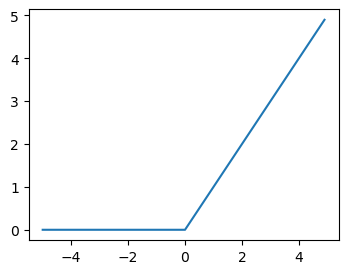

In [6]:
relu = lambda x: np.maximum(x, 0)
x = np.arange(-5, 5, 0.1)
plt.figure(figsize=(4, 3))
plt.plot(x, relu(x));

In [ ]:
class ReLU:
    def __call__(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, d):
        return d * (self.x > 0)

    def update(self, lr):
        pass

- `__init__()`  
    パラメータを持たないので何もしない．記述不要．

- `__call__()`  
    入力が0以上ならそれをそのまま出力し，0未満なら0を出力．逆伝播用に入力された値を保持しておく．

- `backward()`  
    勾配は，順伝播時の入力が0以上なら1，0未満なら0なので，それを$d$にかけて次の層に渡す．

- `update()`  
    パラメータを持たないので何もしない．あとで楽するために定義だけしておく．


## NN

定義した層をNNとしてまとめるクラスを定義する．  
kerasとかPyTorchでいうところの`Sequential`みたいなやつを目指す．

In [ ]:
class NeuralNetwork:
    def __init__(self, *layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def backward(self, d):
        for layer in self.layers[::-1]:
            d = layer.backward(d)
        return d

    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

- `__init__()`  
    層を順番に入力して初期化する．

- `__call__()`  
    順伝播．`__call__()`メソッドを順番に呼び出すだけ．

- `backward()`  
    逆伝播．`backward()`メソッドを逆順に呼び出すだけ．

- `update()`  
    パラメータの更新．`update()`メソッドを順番に呼び出すだけ．